Soil moisture drydowns refer to the rate at which soil loses its moisture content over time, typically following a rainfall event. The initial rate of moisture loss is typically rapid, slowing down as the soil reaches a lower moisture content. Thus, this process is often described by an exponential decay model. 

In this exercise we will extract drydown events from a time series of rootzone soil moisture. Basically, a drydown represents the period of moisture loss between precipitation events. Since in this region small rainfall events don't usually contribute to appreciable soil moisture recharge, we will set a tolerance level to ignore small rainfall events.

## Model description

$$ SWC = A \ e^{-t/\tau} + \theta_{res}$$

$SWC$ = Soil water content in $m^{3}/m^{3}$<br>
$A$ = The initial soil water content $m^{3}/m^{3}$. Soil water at time $t=0$<br>
$t$ = Days since rainfall event<br>
$\tau$ = Constant that modulates the rate at which the soil dries<br>
$\theta_{res}$ = Residual soil water content $m^{3}/m^{3}$.


In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pprint import pprint


In [2]:
# Define model using an anonymous lamda function
A = 0.15 # Initial soil moisture minus the residual moisture. 
theta_res = 0.10 # m3/m3 
model = lambda t,tau: A * np.exp(-t/tau) + theta_res;
xrange = np.arange(30)


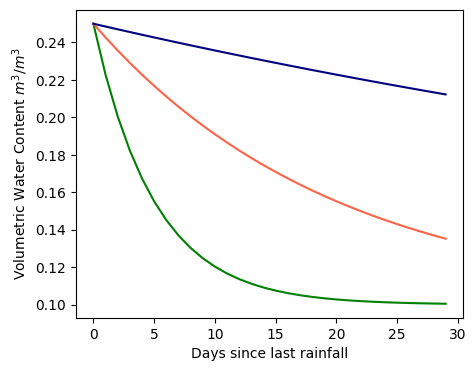

In [14]:
# Create figure with example drydowns
plt.figure(figsize=(5,4))

# Rapid decay. Typical of summer, coarse soils, and actively growing vegetation
plt.plot(xrange, model(xrange,5), color='green')     

# Drydowns during moderate atmospheric demand (spring and fall)
plt.plot(xrange, model(xrange,20), color='tomato')

# Drydown during low atmospheric demand (winter)
plt.plot(xrange, model(xrange,100), color='navy')

plt.xlabel('Days since last rainfall')
plt.ylabel('Volumetric Water Content $m^3/m^3$')
plt.show()


## Load dataset

In [11]:
# Load data
df = pd.read_csv('../datasets/kings_creek_2022_2023_daily.csv',parse_dates=['datetime'])
df.head()


,datetime,pressure,tmin,tmax,tavg,rmin,rmax,prcp,srad,wspd,wdir,vpd,vwc_5cm,vwc_20cm,vwc_40cm,soiltemp_5cm,soiltemp_20cm,soiltemp_40cm,battv,discharge
0,2022-01-01,96.838,-14.8,-4.4,-9.60,78.475,98.012,0.25,2.098,5.483,0.969,0.028,0.257,0.307,0.359,2.996,5.392,7.425,8714.833,0.0
1,2022-01-02,97.995,-20.4,-7.2,-13.80,50.543,84.936,0.25,9.756,2.216,2.023,0.072,0.256,0.307,0.358,2.562,4.250,6.692,8890.042,0.0
2,2022-01-03,97.844,-9.4,8.8,-0.30,40.622,82.662,0.50,9.681,2.749,5.667,0.262,0.255,0.307,0.358,2.454,3.917,6.208,8924.833,0.0
3,2022-01-04,96.419,0.1,8.6,4.35,48.326,69.402,0.25,8.379,5.806,2.627,0.363,0.289,0.319,0.357,2.496,3.754,5.842,8838.292,0.0
4,2022-01-05,97.462,-11.1,-2.2,-6.65,50.341,76.828,0.00,5.717,4.207,1.251,0.126,0.313,0.337,0.357,1.688,3.429,5.567,8848.083,0.0


In [12]:
# Convert date strings into pandas datetie format
df.insert(1, 'doy', df['datetime'].dt.dayofyear)


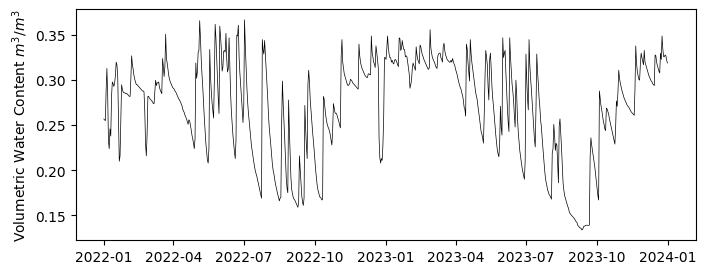

In [15]:
# Plot timeseries of soil moisture and EDDI
plt.figure(figsize=(8,3))
plt.plot(df['datetime'], df['vwc_5cm'], color='k', linewidth=0.5)
plt.ylabel('Volumetric Water Content $m^3/m^3$')
plt.show()


In [ ]:
# Find residual volumetric water content
# We can also approximate this value by taking the first or fifth percentiles for example
theta_res = df['v'].min()
print(theta_res)

In [ ]:
# Iterate over soil moisture timeseries to retrieve drydowns
drydown_counter = 0
day_counter = 0

# Initialize drydowns
drydowns = [{'date':[],'VWC':[],'doy':[],'days':[],'length':[]}]

# We start the loop on the second day
for i in range(1,len(df)):
    delta = df["VWC5CM"][i] - data["VWC5CM"][i-1]
    
    if delta < 0:
        drydowns[drydown_counter]['date'].append(df['TIMESTAMP'][i])
        drydowns[drydown_counter]['VWC'].append(df['VWC5CM'][i])
        drydowns[drydown_counter]['doy'].append(df['DOY'][i])
        drydowns[drydown_counter]['days'].append(day_counter)
        drydowns[drydown_counter]['length'] = day_counter+1
        day_counter += 1
        
    else:
        drydown_counter += 1
        day_counter = 0
        drydowns.append({'date':[],'VWC':[],'doy':[],'days':[],'length':[]})


In [ ]:
drydowns_clean = []
for i in range(len(drydowns)):
    if (drydowns[i]['length'] != [] and drydowns[i]['length'] > 5):
        drydowns_clean.append(drydowns[i])
        
print('There are a total of',len(drydowns_clean),'drydowns')   


In [ ]:
# Print dictionary with all the data for the first drydown period.
# The pretty print module just makes the dictionary easy to read. Keys are sorted alphabetically
pprint(drydowns_clean[0])

## Overlay soil moisture timeseries and extracted drydowns

In [ ]:
f = figure(width=500, height=300, x_axis_type='datetime')
f.line(df['TIMESTAMP'], df['VWC5CM'])

for i in range(len(drydowns_clean)):
    f.line(drydowns_clean[i]['date'],drydowns_clean[i]['VWC'], line_color='red', line_width=2)
    
f.yaxis.axis_label = 'Volumetric Water Content m³/m³'
show(f)

## Overlay soil moisture timeseries, extracted drydowns, and fitted model

It's important to highlight that:

- the "x" variable, in this case $t$ needs to be defined first in the lambda function

- the lambda function needs to be defined in each iteration to ensure that $A$ is updated with the initial soil moisture of the current drydown period in the iteration process.

- It is possible to also fit $A$, but since we do know the value of the parameter from the soil moisture signal it is better to force the model thourhg this value and only optimize tau.

- The $\theta_{res} is considered constant. In other words, for any day of the year it assumed that the soil moisture tends towards this point.

- Values of $\tau$ are inversely related to the drydown rate

In [ ]:
for i in range(len(drydowns_clean)):
    xdata = drydowns_clean[i]['days']
    ydata = drydowns_clean[i]['VWC']
    A = drydowns_clean[i]['VWC'][0] - theta_res # Initial soil moisture minus theta_res
    model = lambda t,tau: A * np.exp(-t/tau) + theta_res; # Define lambda function in each iteration
    par_opt, par_cov = curve_fit(model, xdata, ydata)
    drydowns_clean[i]['tau'] = par_opt[0]


In [ ]:
f = figure(width=700,height=300, x_axis_type='datetime')
f.line(df['TIMESTAMP'], df['VWC5CM'])

for i in range(len(drydowns_clean)):
    #f.line(drydowns_clean[i]['date'],drydowns_clean[i]['VWC'], line_color='gray',line_width=4)
    A = drydowns_clean[i]['VWC'][0] - theta_res
    model = lambda t,tau: A * np.exp(-t/tau) + theta_res;
    f.line(drydowns_clean[i]['date'],model(np.array(drydowns_clean[i]['days']), drydowns_clean[i]['tau']),
           line_color='red',
           line_width=2)
    
show(f)
